In [1]:
# Imports
import sys
sys.path.append('../')
import tensorflow as tf
import tensorflow_datasets as tfds
from helper import visualize_classification_image_samples, visualize_predictions
from helper import fast_benchmark, set_model_config
from helper import plot_loss
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Global variables
model_config = set_model_config('cifar_10')

'''Create a random seed generator for randomized TF ops'''
rng = tf.random.Generator.from_seed(123, alg='philox')

2023-12-03 20:56:45.025981: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 20:56:45.802899: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 20:56:45.802986: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 20:56:45.804784: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 20:56:46.025931: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 20:56:46.028990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Load the CIFAR-10 dataset
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Access and print dataset information
print("CIFAR-10 dataset information:")
print(f"Number of classes: {ds_info.features['label'].num_classes}")
print(f"Class names: {ds_info.features['label'].names}")
print(f"Number of training examples: {ds_info.splits['train'].num_examples}")
print(f"Dataset splits: {list(ds_info.splits.keys())}")
print(f"Dataset description: {ds_info.description}")

CIFAR-10 dataset information:
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of training examples: 50000
Dataset splits: ['train', 'test']
Dataset description: The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/home/dimitris/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title 

In [ ]:
# Iterate the dataset 
iterator = iter(ds_train.take(3))

for i in range(3):
    image, label = next(iterator)
    print(f'Sample {i} tensor shape: {image.shape}')
    print(f'Sample {i} class label: {label}')

2023-12-03 20:57:07.854931: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


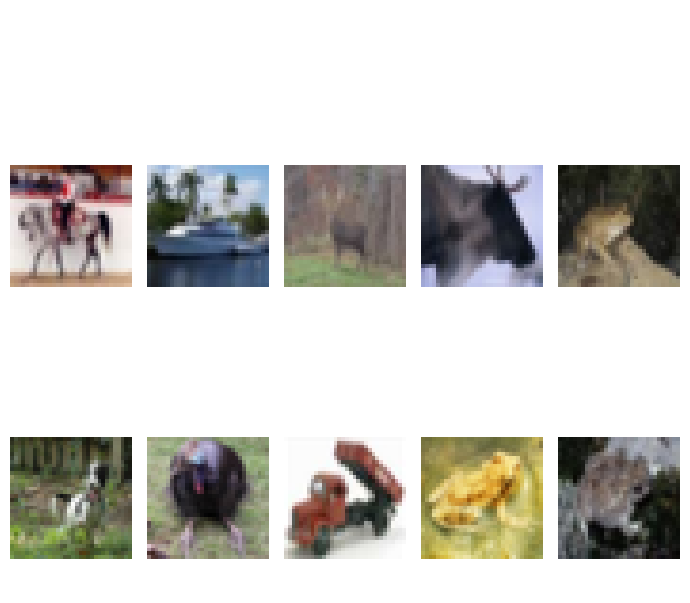

In [4]:
# Visualize a grid of samples from the training set
with plt.style.context('dark_background'):
    visualize_classification_image_samples(ds_train, 10, ds_info, g_shape=(2,5))

In [ ]:
# Pre-processing
def normalize_image(image: tf.Tensor,label: tf.Tensor)-> (tf.Tensor, tf.Tensor):
    '''Define a normalization function that rescales 
    the pixel values from [0,255] uint8 to float32 [0,1]
    '''
    return tf.cast(image, tf.float32) / 255., label

# Augmentations
def augment_image(image_label: tuple, seed)-> (tf.Tensor, tf.Tensor):
    '''Apply basic augmentations on the training dataset samples
    in order to induce extra variance to our dataset. This can help
    our model generalize in a better way. Augmentations applied are 
    random horizontal flip, random crop and random rotation by 45 degrees.'''

    image, label = image_label
    new_seed = tf.random.split(seed, num=1)[0, :]
    image = tf.image.stateless_random_flip_left_right(image, new_seed)

    angle = tf.random.uniform(shape=(), minval=-45, maxval=45, dtype=tf.float32)
    image = tf.image.rot90(image, k=tf.cast(angle / 90, dtype=tf.int32))

    image = tf.image.stateless_random_crop(value= image, size= (32,32,3), seed= new_seed)

    return image, label


def random_wrapper(image: tf.Tensor, label: tf.Tensor)-> (tf.Tensor, tf.Tensor):
    '''Wrapper function for our augmentations to generate a new random 
    seed on each call. This way we can indeed have random augmentations 
    for each sample.'''

    seed = rng.make_seeds(2)[0]
    image, label = augment_image((image, label), seed)
    return image,label

# Generate the validation set from the training set
validation_size = int(model_config['val_size'] * ds_info.splits['train'].num_examples) 

# Create the validation dataset
ds_val = ds_train.take(validation_size)
ds_train = ds_train.skip(validation_size)

# Print the number of examples in the training and validation sets
print("Number of images in training set:", ds_info.splits['train'].num_examples - validation_size)
print("Number of images in validation set:", validation_size)
print("Number of images in test set:", ds_info.splits['test'].num_examples)

# Pipelining pre-processing, augmentations, batching and caching of the training dataset.
''''Order of things: 1. Caching Dataset into memory
                     2. Shuffling dataset to introduce randomness on each training epoch
                     3. Apply augmentations to the shuffled dataset using parallel mapping
                     4. Batch dataset and normalize the images using vectorized mapping 
                     5. Prefetch dataset for performance optimization'''

ds_train = ds_train.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples, reshuffle_each_iteration=True)
ds_train = ds_train.map(random_wrapper, 
                        num_parallel_calls=tf.data.AUTOTUNE)
# ds_train = ds_train.batch(model_config['batch_size']).map(normalize_image)
ds_train = ds_train.batch(model_config['batch_size']).prefetch(tf.data.AUTOTUNE)

# Prepare the validation set
ds_val = ds_val.cache()
ds_val = ds_val.shuffle(validation_size, reshuffle_each_iteration=True)
ds_val = ds_val.batch(model_config['batch_size']).map(normalize_image)
# ds_val = ds_val.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
# ds_val = ds_val.batch(model_config['batch_size'])
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)


# Prepare the test set 
ds_test = ds_test.batch(model_config['batch_size']).map(normalize_image)
ds_test = ds_test.cache()
ds_test = ds_test.shuffle(ds_info.splits['test'].num_examples)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


In [ ]:
""" Benchmark our training dataset for 2 epochs to test our input pipeline's efficiency 
    using parallel mapping """ 
print('Run before caching training dataset...')
fast_benchmark(ds_train)
print('Second run after caching training dataset...')
fast_benchmark(ds_train)

In [ ]:
""" Benchmark our val dataset for 2 epochs to test our input pipeline's efficiency 
    using vectorized mapping """ 
print('Run before caching validation dataset...')
fast_benchmark(ds_val)
print('Second run after caching validation dataset...')
fast_benchmark(ds_val)

In [ ]:
# Create a model using the Keras Sequential API
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define our model's architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', 
           data_format= 'channels_last', 
           input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Conv2D(256, (3, 3), activation='relu'),
    # MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    # Dense(128, activation='relu'),
    Dense(model_config['n_classes'], activation = None)
], name='cifar10_model_1.0')

# Compile and configure the model for training
if model_config['optimizer'].lower() == 'adam':
    optimizer = Adam(learning_rate=model_config['learning_rate'])

# Set Early Stopping strategy after 5 epochs of no improvement for validation set
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)


model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='Accuracy'),
                       tf.keras.metrics.SparseTopKCategoricalAccuracy(name= 'TopKAccuracy')]
              )

# Get a detailed view of how the defined model looks
model.summary()

In [ ]:
""" Train the model, inspect the loss curve during training and experiment 
    with different architectures. Take inspiration from the idea below or 
    try something one of your own...!
    
    Experiment idea: 1. Redifine the model's architecture with an extra convolutional
                     or dense layers and compare the models 
                     2. Try setting a different learning rate and optimizer in the model's settings
                     """
# Train model and plot losses
history = model.fit(ds_train, epochs= int(model_config['training_epochs']), 
                    validation_data= ds_val, 
                    callbacks = [callback])

# Plot with dark backgorund
with plt.style.context('dark_background'):
    plot_loss(history)

In [ ]:
"""Evaluate the model on the test set
   and inspect the results. 
   How reliable is our model? How do the test metrics compare with your training 
   or validation metrics ? """

evaluation_result = model.evaluate(ds_test, verbose= 0)

# Print and log the evaluation metrics
test_loss = evaluation_result[0]
test_metrics = evaluation_result[1:]

# Print metrics
print("--------Test Metrics--------")
print("Test Loss:", test_loss)
print('Accuracy:', test_metrics[0])
print('TopKAccuracy: ', test_metrics[1])
print("---------------------------")


In [ ]:
""" Run inference on the test set for 10 samples and visualize 
    predictions versus true labels """
test_iterator = iter(ds_test.take(1))
single_batch = next(test_iterator)
images = single_batch[0][:15]
true_labels = list(single_batch[1][:15].numpy())
predictions = model.predict(images, verbose= 0)

# Plot with dark backgorund
with plt.style.context('dark_background'):
    visualize_predictions(images, true_labels, predictions, ds_info, num_samples= 15)